In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [3]:
df = pd.read_csv("combined_energy_data.csv")

C:\miniconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5,6,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preprocessing

In [4]:
## convert it to datetime
df['datetime'] = pd.to_datetime(df.datetime)

In [5]:
agg_columns =  ["datetime","Wind"]
required_columns = ["Hours"] + agg_columns + [i for i in df.columns[37:]]

In [6]:
#the
df.datetime.min() , df.datetime.max()

(Timestamp('2016-12-31 22:00:00'), Timestamp('2020-07-17 21:45:00'))

In [7]:
df_agg = df[agg_columns].groupby([df.datetime.dt.floor("H")]).agg(["mean","median","max","min","std"])

In [8]:
df_agg.columns = df_agg.columns.map('_'.join)

In [9]:
df_agg = df_agg.reset_index()

In [10]:
df_agg.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std
0,2016-12-31 22:00:00,289.0,289.0,311.0,267.0,31.112698
1,2016-12-31 23:00:00,359.0,359.0,367.0,351.0,11.313708
2,2017-01-01 00:00:00,357.0,357.0,360.0,354.0,4.242641
3,2017-01-01 01:00:00,340.5,340.5,341.0,340.0,0.707107
4,2017-01-01 02:00:00,384.0,384.0,392.0,376.0,11.313708


In [11]:
df_merged = df_agg.merge(df[required_columns], how="left", on="datetime")

In [12]:
df_merged.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Hours,Wind,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2016-12-31 22:00:00,289.0,289.0,311.0,267.0,31.112698,00:00,267.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-12-31 23:00:00,359.0,359.0,367.0,351.0,11.313708,01:00,351.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 00:00:00,357.0,357.0,360.0,354.0,4.242641,02:00,360.0,1.86,212.0,...,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
3,2017-01-01 01:00:00,340.5,340.5,341.0,340.0,0.707107,03:00,340.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 02:00:00,384.0,384.0,392.0,376.0,11.313708,04:00,376.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_interpolated = df_merged.interpolate(method="linear")

In [47]:
df_interpolated = df_interpolated[2:]

## Feature selections through AR and PAR

In [36]:
import matplotlib.pyplot as plt
import seaborn as snn

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [37]:
## plot AR
def plot_auto_regression(data):
    fig , axs = plt.subplots(1,2,figsize=(20,8))
    lags = [30*24,90*24]

    for ax, lag in zip(axs.flatten(),lags):
        plot_acf(data,ax=ax, lags=lag)
    plt.plot()


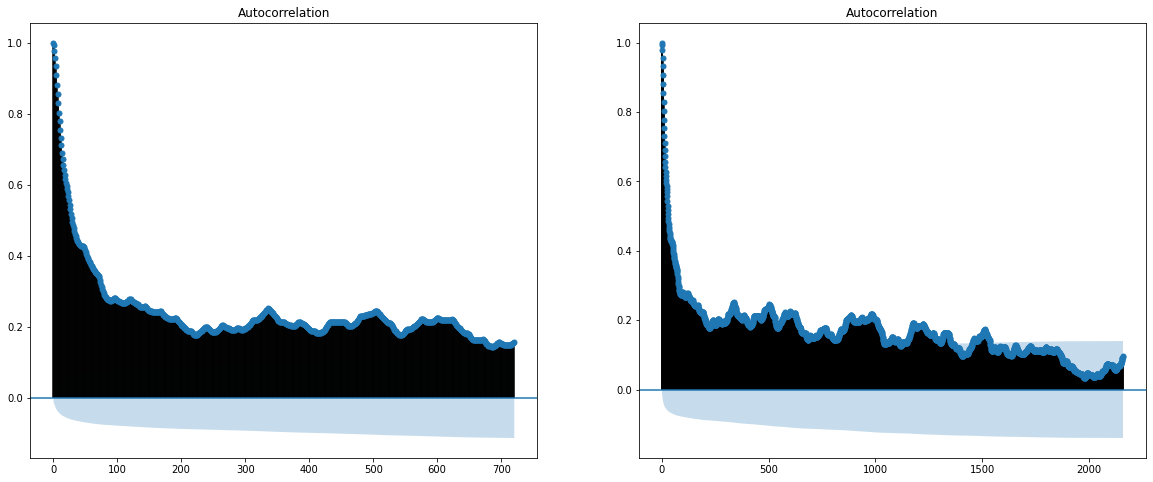

In [38]:
plot_auto_regression(df_interpolated.Wind)

In [39]:
hours_list = ["0{}:00".format(i)  for i in range(10)] + ["{}:00".format(i)  for i in range(10,25)]

In [40]:
df_interpolated.columns

Index(['datetime', 'Wind_mean', 'Wind_median', 'Wind_max', 'Wind_min',
       'Wind_std', 'Hours', 'Wind', 'guitrancourt_Speed(m/s)',
       'guitrancourt_Direction (deg N)', 'lieusaint_Speed(m/s)',
       'lieusaint_Direction (deg N)', 'lvs-pussay_Speed(m/s)',
       'lvs-pussay_Direction (deg N)', 'parc-du-gatinais_Speed(m/s)',
       'parc-du-gatinais_Direction (deg N)', 'arville_Speed(m/s)',
       'arville_Direction (deg N)', 'boissy-la-riviere_Speed(m/s)',
       'boissy-la-riviere_Direction (deg N)', 'angerville-1_Speed(m/s)',
       'angerville-1_Direction (deg N)', 'angerville-2_Speed(m/s)',
       'angerville-2_Direction (deg N)', 'guitrancourt-b_Speed(m/s)',
       'guitrancourt-b_Direction (deg N)', 'lieusaint-b_Speed(m/s)',
       'lieusaint-b_Direction (deg N)', 'lvs-pussay-b_Speed(m/s)',
       'lvs-pussay-b_Direction (deg N)', 'parc-du-gatinais-b_Speed(m/s)',
       'parc-du-gatinais-b_Direction (deg N)', 'arville-b_Speed(m/s)',
       'arville-b_Direction (deg N)', 'bo

In [29]:
def plot_all_acf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))

    for hour, ax in zip(hours_list, axs.flatten()):
            plot_acf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name], ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
    plt.plot()
    
def plot_all_pacf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))
    
    for hour, ax in zip(hours_list, axs.flatten()):
            plot_pacf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name], ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
    plt.plot()


## Model